In [ ]:
!pip install -q wandb transformers accelerate bitsandbytes scikit-learn pandas seaborn matplotlib

print("✅ Installation complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 9.7 MB/s eta 0:00:00
✅ Installation complete.


In [ ]:
import os
import json
import pandas as pd
import numpy as np

print("🔍 Searching for dataset...")
data = []
root_path = None
base_search_dir = "/content"

for root, dirs, files in os.walk(base_search_dir):
    if "train" in dirs:
        potential_path = os.path.join(root, "train")
        if "algebra" in os.listdir(potential_path):
            root_path = potential_path
            break

if not root_path:
    if os.path.exists("/content/dataset.zip"):
        print("📦 Unzipping dataset...")
        os.system("unzip -q -o /content/dataset.zip -d /content/math_data")
        root_path = "/content/math_data/MATH/train"
    else:
        raise SystemExit("❌ ERROR: Please upload 'dataset.zip' to the Files sidebar.")

print(f"📂 Loading data from: {root_path}")

for root, dirs, files in os.walk(root_path):
    for file in files:
        if file.endswith(".json"):
            try:
                with open(os.path.join(root, file), 'r') as f:
                    content = json.load(f)
                    text = content.get("question") or content.get("problem") or str(content)
                    topic = os.path.basename(root)
                    data.append({"text": text, "label": topic})
            except Exception as e:
                pass
df = pd.DataFrame(data)
print(f"✅ Successfully loaded {len(df)} questions across {df['label'].nunique()} topics.")
df.head(3) 

🔍 Searching for dataset...
📂 Loading data from: /content/math_data/MATH/train
✅ Successfully loaded 7500 questions across 7 topics.


,text,label
0,Two different numbers are randomly selected fr...,counting_and_probability
1,"Nine delegates, three each from three differen...",counting_and_probability
2,Rachel has two identical basil plants and an a...,counting_and_probability


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

print("🧠 Preprocessing text...")
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['text'].astype(str))
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("🚀 Training SVM Classifier (Linear Kernel)...")
model = SVC(kernel='linear')
model.fit(X_train, y_train)

print("✅ Training Complete. Evaluating...")
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

🧠 Preprocessing text...
🚀 Training SVM Classifier (Linear Kernel)...
✅ Training Complete. Evaluating...
                          precision    recall  f1-score   support

                 algebra       0.67      0.76      0.71       349
counting_and_probability       0.71      0.68      0.70       154
                geometry       0.73      0.81      0.77       174
    intermediate_algebra       0.81      0.68      0.74       259
           number_theory       0.69      0.74      0.72       174
              prealgebra       0.55      0.54      0.54       241
             precalculus       0.91      0.78      0.84       149

                accuracy                           0.71      1500
               macro avg       0.73      0.71      0.72      1500
            weighted avg       0.71      0.71      0.71      1500



🎉 Dashboard Ready! View charts here: https://wandb.ai/aditya7-vellore-institute-of-technology/ms-sarah-classifier/runs/2udvhwow


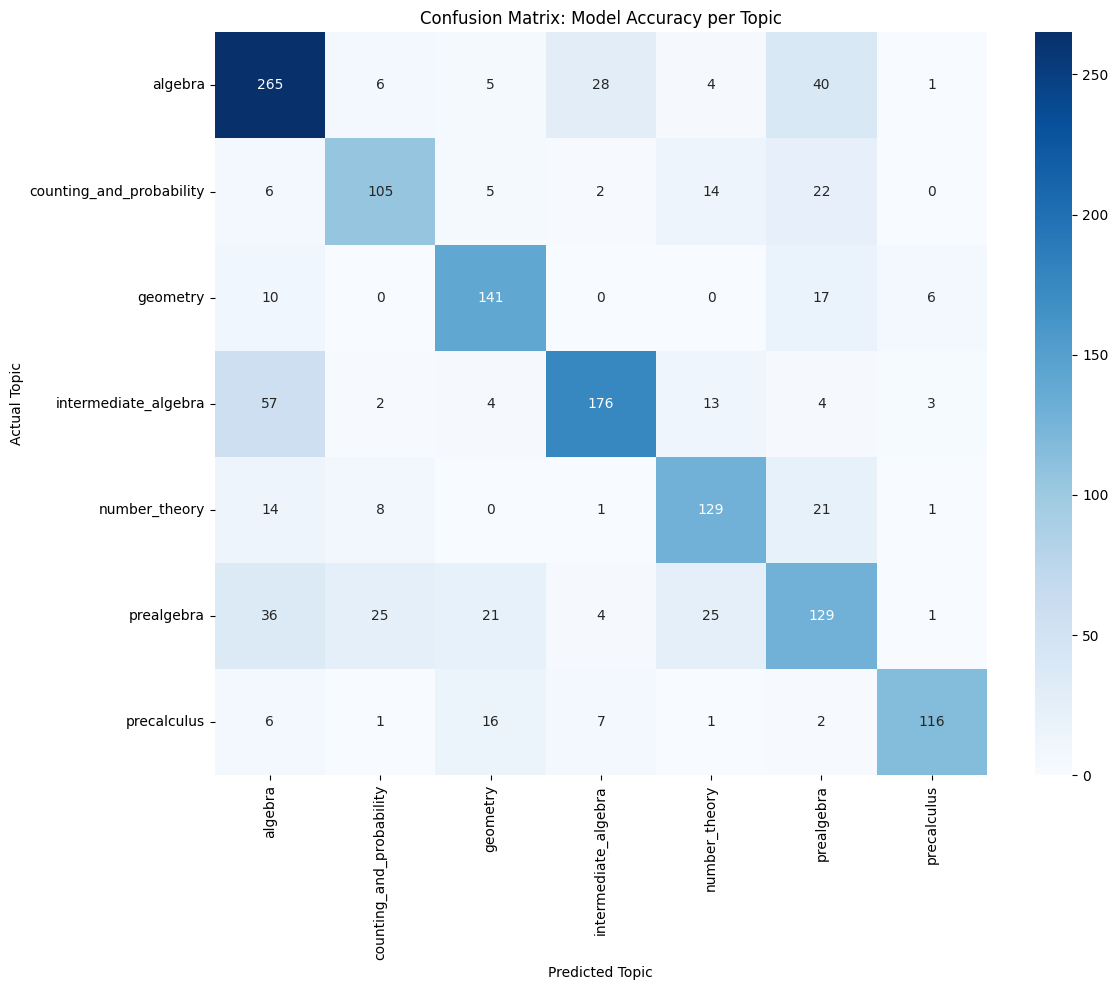

In [ ]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

wandb.login()
run = wandb.init(project="ms-sarah-classifier", name="Final_Submission", reinit=True)

class_names = model.classes_
cm = confusion_matrix(y_test, predictions, labels=class_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Model Accuracy per Topic')
plt.ylabel('Actual Topic')
plt.xlabel('Predicted Topic')
plt.tight_layout()

plt.savefig("confusion_matrix.png")
wandb.log({"confusion_matrix": wandb.Image("confusion_matrix.png")})

report = classification_report(y_test, predictions, output_dict=True)
data_table = []
for topic in class_names:
    if topic in report:
        data_table.append([topic, report[topic]['f1-score']])

table = wandb.Table(data=data_table, columns=["Topic", "F1 Score"])
wandb.log({"accuracy_chart": wandb.plot.bar(table, "Topic", "F1 Score", title="F1 Score by Topic")})

print(f"🎉 Dashboard Ready! View charts here: {run.get_url()}")
wandb.finish()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

print("Loading Mistral-7B (Quantized)...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
llm_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

def solve_question(question):
    prompt = f"[INST] You are a math teacher. Solve this problem step-by-step and provide the final answer:\n{question} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    outputs = llm_model.generate(**inputs, max_new_tokens=1000)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

if len(df) > 0:
    sample = df.sample(1).iloc[0]
    print("\n" + "="*50)
    print(f"📝 Topic: {sample['label']}")
    print(f"❓ Question: {sample['text'][:200]}...")
    print("-" * 50)
    print("💡 AI Solution (Generating... this may take 1-2 mins):")
    print(solve_question(sample['text']))
    print("="*50)
else:
    print("⚠️ Error.")

🤖 Loading Mistral-7B (Quantized)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



📝 Topic: geometry
❓ Question: Amy and Belinda each roll a sheet of 6-inch by 8-inch paper to form a cylindrical tube. Amy tapes the two 8-inch sides together without overlap. Belinda tapes the two 6-inch sides together without ove...
--------------------------------------------------
💡 AI Solution (Generating... this may take 1-2 mins):
[INST] You are a math teacher. Solve this problem step-by-step and provide the final answer:
Amy and Belinda each roll a sheet of 6-inch by 8-inch paper to form a cylindrical tube. Amy tapes the two 8-inch sides together without overlap. Belinda tapes the two 6-inch sides together without overlap. What is $\pi$ times the positive difference of the volumes of the two tubes? [/INST] To find the volume of each cylindrical tube, we first need to calculate the area of the base and the height.

For Amy's tube:
The base area is the area of a rectangle with sides 8 inches and 6 inches (since she rolled up the shorter side):

Area_Amy = length * width
Area_Amy 